# Multi-Scenario MORDM Overijssel
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate what possible strategies the Overijjsel is likely to use to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies for the Overijjsel province, namely minimizing casualties and damages across the model runtime in dike rings 4-5 and minimizing dike investment costs for all dike rings. By performing this analysis, Gelderland gains strategic information on which strategies the downstream province is likely to follow, if they choose to only take into account their own objectives. 

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform.

In [2]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/10000Scenarios_NoAction_PF1.tar.gz"

#Specify province
province = "Overijssel"

## Model Specification

In [3]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(7)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [11]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/10000Scenarios_NoAction_PF1.tar.gz


In [19]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(5).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.01,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 995/10000 nfe
[MainProcess/INFO] generation 15: 1493/10000 nfe
[MainProcess/INFO] generation 20: 1993/10000 nfe
[MainProcess/INFO] generation 25: 2493/10000 nfe
[MainProcess/INFO] generation 30: 2988/10000 nfe
[MainProcess/INFO] generation 35: 3474/10000 nfe
[MainProcess/INFO] generation 40: 3911/10000 nfe
[MainProcess/INFO] generation 45: 4248/10000 nfe
[MainProcess/INFO] generation 50: 4576/10000 nfe
[MainProcess/INFO] generation 55: 4898/10000 nfe
[MainProcess/INFO] generation 60: 5201/10000 nfe
[MainProcess/INFO] generation 65: 5519/10000 nfe
[MainProcess/INFO] generation 70: 5838/10000 nfe
[MainProcess/INFO] generation 75: 6156/10000 nfe
[MainProcess/INFO] generation 80: 6476/10000 nfe
[MainProcess/INFO] generation 85: 6780/10000 nfe
[MainProcess/INFO] generation 90: 7085/10000 nfe
[MainProcess/INFO] generation 95: 7397/10000

In [7]:
results, convergence = results_epsilon_0_1

In [8]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Overijjsel.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/10000nfe_BaseCaseMORDM_Overijjsel.tar.gz


In [25]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Overijjsel.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/20000nfe_BaseCaseMORDM_Overijjsel.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

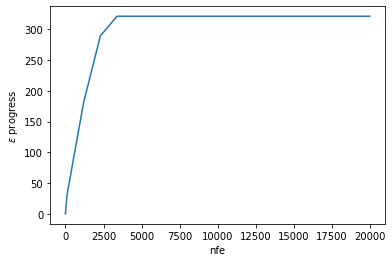

In [26]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Resulting optimal policies
The algorithm found a singleolutions., which is the most optimal for the reference, worst-case case scenario. The algorithm converges after around 3800 nfes, and there is a single policy pareto dominant to all other possible solutions: The do-nothing alternatives. This implicates that for the selected worst case scenario, it is optimal for the Overijssel province to not take any action. This is an important insight, as it shows that when thinking about the worst-case scenario in terms of deaths, it is Gelderland that has to take action. However, it shows another important aspect to consider when confronted with deep uncertainty: The necessaty to assess this specific policy resulting from MORDM under deep uncertainty for the Overijssel province and then run multiple optimizations based on differently selected reference case scenarios

In [27]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A4 Expected Annual Damage,A5 Expected Annual Damage,A4 Expected Number of Deaths,A5 Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Re-Evaluate under deep uncertainty
We now re-evaluate the single-outcome under deep uncertainty for the Overijssel province.

In [30]:
policies = results.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [31]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [32]:
#Save results
save_results(results, "../results/DeepUncertainty1policy_1000scenarios_Overijjsel.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty1policy_1000scenarios_Overijjsel.tar.gz


### Signal-to-noise Ratio
To assess the robustness of the do-nothing policy for Overijssel, we calculate the signal-to-noise ratio.

In [7]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [8]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A1_5 Dike Investment Costs,A4 Expected Annual Damage,A4 Expected Number of Deaths,A5 Expected Annual Damage,A5 Expected Number of Deaths,Evacuation Costs,Room for River Investment Costs
0,0.0,5.840764e+14,0.000118,1.046700e+16,0.008415,0.0,0.0


### Maximum Regret
As the maximum regret measure compares different policies against each other, it is not feasible to calculate when only one single optimal policy is assessed

# !
# Start running from here
## (After running the first three cells)

In [9]:
#Load results
results = load_results("../results/DeepUncertainty8policies_1000scenarios_Overijjsel.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ignasicortes/Documents/EPA/Year_1/Q4/1.Model_Based_Decision_Making/model-based-decision-making/results/DeepUncertainty8policies_1000scenarios_Overijjsel.tar.gz


## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [10]:
x = experiments.iloc[:,0:19]

outcomes["selection"] = outcomes["A4 Expected Annual Damage"] + outcomes["A5 Expected Annual Damage"] + outcomes["A4 Expected Number of Deaths"] + outcomes["A5 Expected Number of Deaths"]

y =  outcomes["selection"] > 0 
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 519 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.141, coverage: 0.27167630057803466, density: 1.0 restricted_dimensions: 6


In [11]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 17, as it shows a good mixture between coverage and density

In [14]:
box.inspect(n_box)


coverage    0.645472
density     0.811138
id                17
mass           0.413
mean        0.811138
res_dim            4
Name: 17, dtype: object

              box 17                                           
                 min         max                      qp values
A.4_pfail   0.000904    0.661754  [-1.0, 2.714413313129453e-09]
A.1_Bmax   30.091208  333.849175    [-1.0, 0.14822985850514236]
A.3_pfail   0.191052    0.999145  [4.989930418277363e-07, -1.0]
A.2_pfail   0.177260    0.999657  [4.705781716242567e-05, -1.0]



In [15]:
box.select(n_box)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}
#Save results
save_results((scens_in_box, outcomes_in_box), '../results/mordm_'+str(n_box)+'_Overijjsel.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/ignasicortes/Documents/EPA/Year_1/Q4/1.Model_Based_Decision_Making/model-based-decision-making/results/mordm_17_Overijjsel.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 

In [13]:
n_box = 17

In [16]:
#Load results
# mordm_results = load_results('../results/mordm_29_Gelderland.tar.gz')
results_df = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), pd.DataFrame(outcomes_in_box)], axis = 1)

In [17]:
#Sum up Deaths and Damages
results_df["Deaths Aggregated"] = results_df["A4 Expected Number of Deaths"] + results_df["A5 Expected Number of Deaths"]
results_df["Damages Aggregated"] = results_df["A4 Expected Annual Damage"] + results_df["A5 Expected Annual Damage"]

In [18]:
#Get the three reference scenarios
scenario_indices = [results_df.sort_values(["Evacuation Costs"]).tail(1).index[0], 
                    results_df.sort_values(["Deaths Aggregated"]).tail(1).index[0], 
                    results_df.sort_values(["Damages Aggregated"]).tail(1).index[0]]
selected = results_df.iloc[scenario_indices, 0:19]

In [19]:
#Create the three reference case scenario instances
scenarios_mordm = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [20]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []
i = 0

for scenario in scenarios_mordm:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, n_nfe, dike_model, convergence_metrics, epsilons))

    #Save results in between
    save_results(results[i], "../results/ms_mordm_"+str(n_nfe)+"nfe_"+province+"_reference"+str(i)+".tar.gz")
    i = i+1


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 500/20000 nfe
[MainProcess/INFO] generation 10: 998/20000 nfe
[MainProcess/INFO] generation 15: 1497/20000 nfe
[MainProcess/INFO] generation 20: 1997/20000 nfe
[MainProcess/INFO] generation 25: 2494/20000 nfe
[MainProcess/INFO] generation 30: 2991/20000 nfe
[MainProcess/INFO] generation 35: 3486/20000 nfe
[MainProcess/INFO] generation 40: 3978/20000 nfe
[MainProcess/INFO] generation 45: 4472/20000 nfe
[MainProcess/INFO] generation 50: 4954/20000 nfe
[MainProcess/INFO] generation 55: 5443/20000 nfe
[MainProcess/INFO] generation 60: 5933/20000 nfe
[MainProcess/INFO] generation 65: 6429/20000 nfe
[MainProcess/INFO] generation 70: 6922/20000 nfe
[MainProcess/INFO] generation 75: 7413/20000 nfe
[MainProcess/INFO] generation 80: 7905/20000 nfe
[MainProcess/INFO] generation 85: 8397/20000 nfe
[MainProcess/INFO] generation 90: 8895/20000 nfe
[MainProcess/INFO] generation 95: 9393/20000

In [22]:
#Load results
results = []
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference0.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference1.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference2.tar.gz"))

[MainProcess/INFO] results loaded succesfully from /Users/ignasicortes/Documents/EPA/Year_1/Q4/1.Model_Based_Decision_Making/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference0.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ignasicortes/Documents/EPA/Year_1/Q4/1.Model_Based_Decision_Making/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference1.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ignasicortes/Documents/EPA/Year_1/Q4/1.Model_Based_Decision_Making/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference2.tar.gz
